# Display Accuracy and Loss

## Load Data

In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os
# _path = '.'
# sys.path.append(os.path.join(_path))
import matplotlib.pyplot as plt

def parse_tf_events_file(events_path, tag, time_horizon=None):
    ea = EventAccumulator(events_path).Reload()
    # print(ea.Tags())
    tag_values, steps = [], []
    for event in ea.Scalars(tag):
        if time_horizon is None or event.step <= time_horizon:
            tag_values.append(event.value)
            steps.append(event.step)
    return steps, tag_values

class ExperimentConfig:
    def __init__(self, base_path, experiment, seeds, algorithms, events, lr_list,
                 alphas, n_clients_list, availabilities, n_rounds, participations, biased_list, train_test):
        """
        base_path: path to the folder logs/
        experiment: name of exp (str: mnist_CI_based_availability)
        seeds: list of seeds
        algorithms: list of algorithms
        events: list of events (e.g. ["global"])
        # b_values:
        lr_list: list of learning rates
        alphas: list of alpha values (for the iid - non iid -ness)
        n_clients_list: list of number of clients
        availabilities: list of availability types
        n_rounds: number of FL rounds
        participations: list with "unknown" and/or "known" (whether we work with the participation probabilities estimator or the true values)
        biased: list of elements of {0, 1} (0=unbiased, 1=biased)
        train_test: "train" or "test"
        """
        self.base_path = base_path
        self.experiment = experiment
        self.seeds = seeds
        self.algorithms = algorithms
        self.events = events
        # self.b_values = b_values
        self.lr_list = lr_list
        self.alphas = alphas
        self.n_clients_list = n_clients_list
        self.availabilities = availabilities
        self.n_rounds = n_rounds
        self.participations = participations
        self.biased_list = biased_list
        self.train_test = train_test

    def get_event_dir(self, algo, lr, seed, event, alpha, n_clients, availability, n_rounds, participation, biased, train_test):
        """
        Returns the path to the saved data corresponding to the parameters given as inputs to this function.
        Intputs:
        algorithm: algorithm (str:fedavg, defvarp or fedstale)
        lr: learning rate (str)
        b: beta (str)
        seed:
        event:
        alpha:
        n_clients:
        availability:
        n_rounds:
        participation:
        biased: 0 or 1 (str)
        train_test: "train" or "test"
        """
        path = f"{self.base_path}/{self.experiment}/{availability}"
        # path += f"/{algo}/b_{b}" if algo == "mixture" else f"/{algo}" # in case we vary beta
        path += f"/biased_{biased}/{algo}"
        path += f"/alpha_{alpha}/lr_{lr}/seed_{seed}/{train_test}/{event}"

        path = os.path.join(self.base_path, self.experiment, availability,
                            "biased_"+biased, algo, "alpha_"+alpha,
                            "lr_"+lr, "seed_"+seed, train_test, event)

        # path = '/'.join([self.base_path, self.experiment, availability,
        #                     "biased_"+biased, algo, "alpha_"+alpha,
        #                     "lr_"+lr, "seed_"+seed, "train", event])

        return path

# Load and Process Experiment Results
def load_experiment_results(config):
    results = [] 
    for lr in tqdm(config.lr_list, desc="Processing experiments"):
        # time_horizon = time_horizons[p]  
        for algorithm in config.algorithms:
            # b_loop = config.b_values if algorithm == 'mixture' else [None] # in case we vary beta
            # for b in b_loop:
            for event in config.events:
                for seed in config.seeds:
                    for a in config.alphas:
                        for n_c in config.n_clients_list:
                            for av in config.availabilities:
                                for part in config.participations:
                                    for biased in config.biased_list:

                                        event_dir = config.get_event_dir(algorithm, lr, seed, 
                                                                            event, a, n_c, av, 
                                                                            config.n_rounds, part, biased, config.train_test) 

                                        # print(event_dir)                                   
                                        files = os.listdir(event_dir)
                                        # print(files)

                                        if os.path.exists(event_dir):
                                            # print('x')
                                            # _, values = parse_tf_events_file(event_dir, tag="Test/Metric", time_horizon=time_horizon)
                                            _, test_accuracy_values = parse_tf_events_file(event_dir, tag="Test/Metric")
                                            _, test_loss_values = parse_tf_events_file(event_dir, tag="Test/Loss")
                                            _, train_accuracy_values = parse_tf_events_file(event_dir, tag="Train/Metric")
                                            _, train_loss_values = parse_tf_events_file(event_dir, tag="Train/Loss")
                                            ### tag can be: 'Train/Loss', 'Train/Metric', 'Test/Loss', 'Test/Metric'
                                            max_accuracy = np.array(test_accuracy_values).max() * 100
                                            results.append({
                                                "algorithm": algorithm, "availability": av,
                                                "alpha": a, "participation": part,
                                                "max_test_accuracy": float(max_accuracy),
                                                "test_accuracy": "Test/Metric",
                                                "test_loss": "Test/Loss",
                                                "train_accuracy": "Train/Metric",
                                                "train_loss": "Train/Loss",
                                                "seed": seed,
                                                "lr": lr, "event": event, "n_clients": n_c,
                                                "biased": biased
                                                # "event_dir": event_dir
                                            })

                                            # "b": float(b) if b else np.nan # in case we vary beta
    return pd.DataFrame(results)

## Plots

In [2]:
def plot_availability_comparison(config, res, metric, folder):
    
    xvalues = [i for i in range(int(config.n_rounds)+1)]

    for lr in config.lr_list:
        for algo in config.algorithms:
            for event in config.events:
                for seed in config.seeds:
                    for a in config.alphas:
                        for n_c in config.n_clients_list:
                            for biased in config.biased_list:
                                # for av in config.availabilities:
                                for part in config.participations:


                                        res_tmp = res[(res.lr == lr) & (res.algorithm == algo) & (res.event == event) &
                                                    (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
                                                    (res.participation == part)]
                                        
                                        # display(res_plot) # this is what we are going to compare
                                        
                                        ### for random equivalents:
                                        # fig = plt.figure(figsize=(6, 4))
                                        # for av in config.availabilities:
                                        #     if 'random' in av:
                                        #         res_plot = res_tmp[res_tmp.availability == av]
                                        #         event_dir = config.get_event_dir(algo, lr, seed, 
                                        #                                         event, a, n_c, av, 
                                        #                                         config.n_rounds, part)  
                                        #         # display(res_plot)
                                        #         # print('xxx')
                                        #         tag = res_plot[metric].values[0]
                                        #         _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                        #         # print(av)
                                        #         # yvalues = res_plot[(res_plot.availability == av)][metric]
                                        #         # print(res_plot[(res_plot.availability == av)][metric])
                                        #         plt.plot(xvalues, test_accuracy_values, label= av)
                                        #         title = ('_').join([algo, 'alpha'+a, 'random', metric])
                                        #         plt.title(title)
                                        # plt.legend()
                                        # plt.grid()
                                        # plt.savefig('figures/accross_availabilities/'+title+'.png', bbox_inches='tight')
                                        # plt.show()

                                        fig = plt.figure(figsize=(6, 4))
                                        for av in config.availabilities:
                                            if 'random' not in av:
                                                res_plot = res_tmp[res_tmp.availability == av]
                                                # event_dir = config.get_event_dir(algo, lr, seed, 
                                                #                                 event, a, n_c, av, 
                                                #                                 config.n_rounds, part)  
                                                event_dir = config.get_event_dir(algo, lr, seed, 
                                                                                event, a, n_c, av, 
                                                                                config.n_rounds, part, biased, config.train_test) 
                                                # display(res_plot)
                                                # print('xxx')
                                                tag = res_plot[metric].values[0]
                                                # print('---------->',tag)
                                                # print('---------->',event_dir)
                                                _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                                # print(av)
                                                # yvalues = res_plot[(res_plot.availability == av)][metric]
                                                # print(res_plot[(res_plot.availability == av)][metric])
                                                plt.plot(xvalues, test_accuracy_values, label= av)
                                                ax = plt.gca()
                                                ax.set_ylim([0, 1])
                                                title = ('_').join([algo, a.replace("100000", "iid").replace("0.1", "non-iid"), metric])
                                                plt.title(title)

                                        plt.legend(loc='lower left') 
                                        ax = plt.gca()
                                        ax.set_facecolor('#EBEBEB')
                                        ax.grid(which='major', color='white', linewidth=1.2)
                                        ax.grid(which='minor', color='white', linewidth=0.6)
                                        # Show the minor ticks and grid.
                                        ax.minorticks_on()
                                        # Now hide the minor ticks (but leave the gridlines).
                                        ax.tick_params(which='minor', bottom=False, left=False)
                                
                                        plt.savefig('figures/'+folder+'/'+title+'.png', bbox_inches='tight')
                                        plt.show()
    
# plot_availability_comparison(config, results_df, "test_accuracy")

In [3]:
def plot_biased_unbiased_comparison(config, res, metric, folder):

    xvalues = [i for i in range(int(config.n_rounds)+1)]

    for lr in config.lr_list:
        
        for event in config.events:
            for seed in config.seeds:
                for a in config.alphas:
                    for n_c in config.n_clients_list:
                        # for av in config.availabilities:
                        for part in config.participations:
                                    
                            for av in config.availabilities:

                                for algo in config.algorithms:

                                    res_tmp = res[(res.lr == lr) & (res.availability == av) & (res.event == event) &
                                                (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
                                                (res.participation == part) & (res.algorithm == algo)]
                                    
                                    # display(res_tmp) # this is what we are going to compare
                                    
                                    fig = plt.figure(figsize=(6, 4))
                                    
                                    
                                    for biased in config.biased_list:
                                        
                                        res_plot = res_tmp[res_tmp.biased == biased]
                                        event_dir = config.get_event_dir(algo, lr, seed, 
                                                                        event, a, n_c, av, 
                                                                        config.n_rounds, part, biased, config.train_test)  

                                        tag = res_plot[metric].values[0]
                                        _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                        
                                        if biased == "0":
                                            plt.plot(xvalues, test_accuracy_values, label="unbiased", color='g')
                                        elif biased == "1":
                                            plt.plot(xvalues, test_accuracy_values, label="biased")
                                        else:
                                            plt.plot(xvalues, test_accuracy_values, label="hybrid", linestyle="--")
                                        ax = plt.gca()
                                        ax.set_ylim([0, 1])
                                        title = ('_').join([av.replace("random_for", "R").replace("carbon-budget-", "").replace("uniform", "unif").replace("nonlinear-optimization-cvxpy", "opt-pb-1"), algo, a.replace("100000", "iid").replace("0.1", "non-iid"), metric])
                                        plt.title(title)
                                        
                                    plt.legend(loc='lower left')
                                    ax = plt.gca()
                                    ax.set_facecolor('#EBEBEB')
                                    ax.grid(which='major', color='white', linewidth=1.2)
                                    ax.grid(which='minor', color='white', linewidth=0.6)
                                    # Show the minor ticks and grid.
                                    ax.minorticks_on()
                                    # Now hide the minor ticks (but leave the gridlines).
                                    ax.tick_params(which='minor', bottom=False, left=False)
                                    
                                    # plt.grid()
                                    plt.savefig('figures/'+folder+'/'+title+'.png', bbox_inches='tight')
                                    plt.show()

## First experiment - participation freq not comparable

Processing experiments:   0%|          | 0/1 [00:00<?, ?it/s]2024-10-09 14:56:20.228953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 14:56:20.241116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 14:56:20.255706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 14:56:20.259938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09

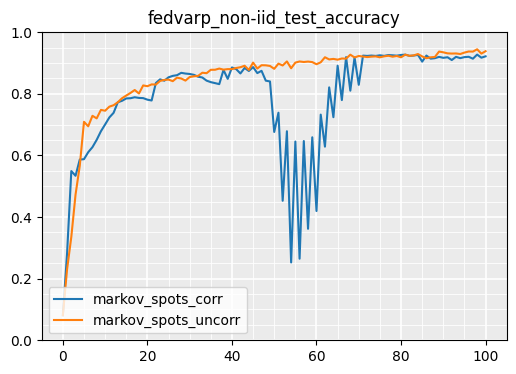

In [4]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedvarp"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov_spots_corr", "markov_spots_uncorr"],
                          n_rounds="100", participations=["known"], biased_list=["0"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder='big_comparison_09_24/comp-av-mat')

Processing experiments: 100%|██████████| 1/1 [00:00<00:00, 31.15it/s]


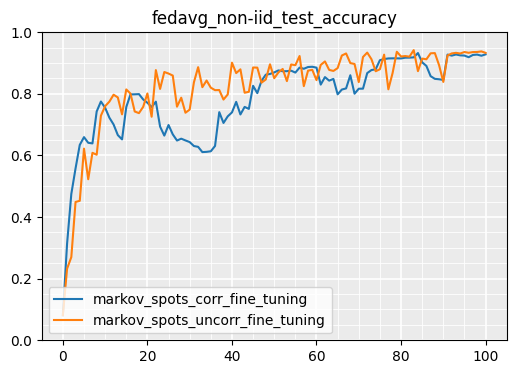

In [5]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedavg"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov_spots_corr_fine_tuning", "markov_spots_uncorr_fine_tuning"],
                          n_rounds="100", participations=["known"], biased_list=["2"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder='big_comparison_09_24/comp-av-mat')

## Second experiment - comparable participation freq - target 0.5 freq

In [6]:
main_folder = 'correlation_experiments/markov-50perc'



### FedVARP

#### No Fine-Tuning

Processing experiments: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


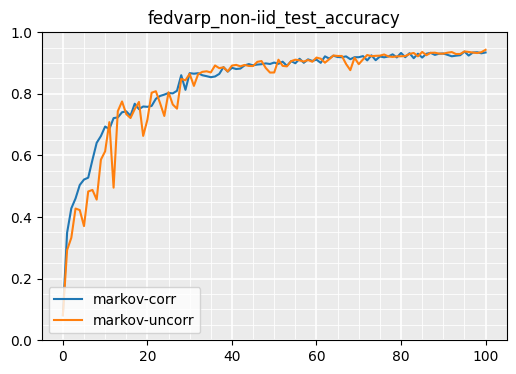

In [7]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedvarp"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov-corr", "markov-uncorr"],
                          n_rounds="100", participations=["known"], biased_list=["0"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder=main_folder+'/comp-av-mat/no-ft')

#### Fine-Tuning

Processing experiments: 100%|██████████| 1/1 [00:00<00:00, 32.85it/s]


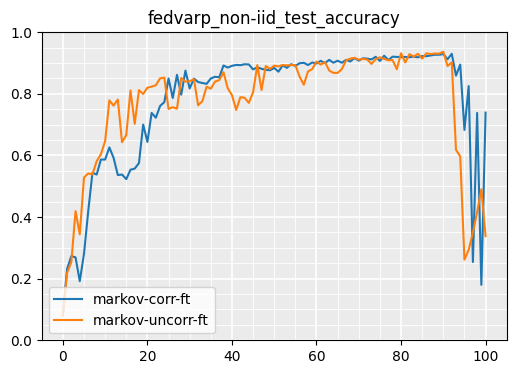

In [8]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedvarp"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov-corr-ft", "markov-uncorr-ft"],
                          n_rounds="100", participations=["known"], biased_list=["0"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder=main_folder+'/comp-av-mat/ft')

### Hybrid-FedAvg

#### No Fine-Tuning

Processing experiments: 100%|██████████| 1/1 [00:00<00:00, 27.96it/s]


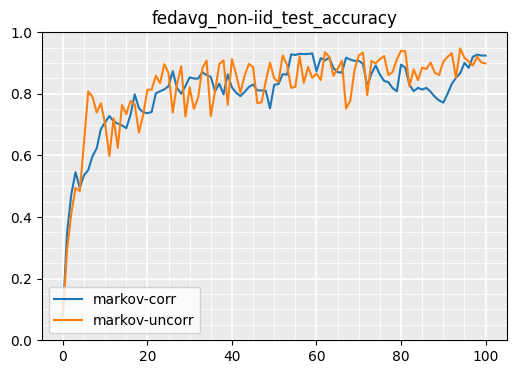

In [9]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedavg"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov-corr", "markov-uncorr"],
                          n_rounds="100", participations=["known"], biased_list=["2"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder=main_folder+'/comp-av-mat/no-ft')

#### Fine-Tuning

Processing experiments: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]


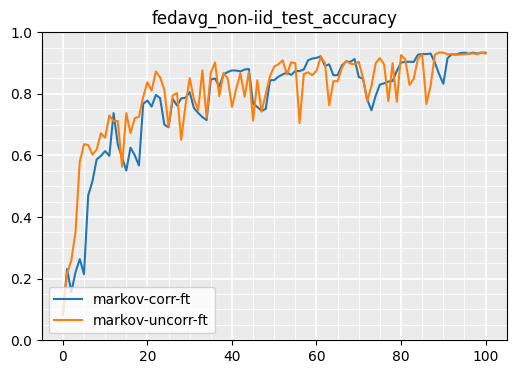

In [10]:
config = ExperimentConfig(base_path=os.path.join('..', 'logs'), experiment="mnist", seeds=["12"],
                          algorithms=["fedavg"], events=["global"],
                          lr_list=["5e-3"], alphas=["0.1"], n_clients_list=["7"],
                          availabilities=["markov-corr-ft", "markov-uncorr-ft"],
                          n_rounds="100", participations=["known"], biased_list=["2"], train_test="train")

results_df = load_experiment_results(config)
plot_availability_comparison(config, results_df, "test_accuracy", folder=main_folder+'/comp-av-mat/ft')

## Appendix

In [11]:
# folder = './logs/mnist_CI_based_availability/clients_7/local_mean/fedavg/known_participation_probs/alpha_0.1/lr_5e-3/seed_12/rounds_100/train/global/events.out.tfevents.1717493789.C11-8C4G9B45HOX.12548.7'
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# event_acc = EventAccumulator(folder)
# event_acc.Reload()
# print(event_acc.Tags()) # Show all tags in the log file
# event_acc.Scalars('Train/Loss')

In [12]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# def parse_tf_events_file(events_path, tag, time_horizon=None):
#     # extract the list of steps (FL rounds) and the list or corresponding values
#     ea = EventAccumulator(events_path).Reload()
#     tag_values, steps = [], []
#     for event in ea.Scalars(tag):
#         if time_horizon is None or event.step <= time_horizon:
#             tag_values.append(event.value)
#             steps.append(event.step)
#     return steps, tag_values


# class ExperimentConfig:
#     def __init__(self, base_path, experiment, seeds, algorithms, events, heterogeneities, b_values, lr_dict
#                  ):
#         self.base_path = base_path
#         self.experiment = experiment
#         self.seeds = seeds
#         self.algorithms = algorithms
#         self.events = events
#         self.heterogeneities = heterogeneities
#         self.b_values = b_values
#         self.lr_dict = lr_dict

#     def get_event_dir(self, p, h, algorithm, lr, b, seed, event):
#         path = f"{self.base_path}/{self.experiment}/p_{p}/h_{h}"
#         path += f"/{algorithm}/b_{b}" if algorithm == "mixture" else f"/{algorithm}"
#         path += f"/lr_{lr}/seed_{seed}/train/{event}"
#         return path

# parse_tf_events_file(folder, 'Train/Loss')